# Flight Delay Prediction - EDA

**Goal:** Predict arrival delays using pre-flight information.

**Dataset:** US Domestic Flights (2015) - 5.8M flights

**Plan:**
1. Load and understand data
2. Clean dataset (remove cancelled/diverted flights)
3. Handle outliers
4. Create features
5. Check correlations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [87]:
df_flights = pd.read_csv("../data/raw/flights.csv", low_memory=False)

## First Look at the Data

Checking:
- Dataset size
- Column types
- Missing values
- Target variable distribution

In [88]:
df_flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
df_flights.shape

(5819079, 31)

In [90]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [91]:
df_flights.isnull().sum() 

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER              14721
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           86153
DEPARTURE_DELAY          86153
TAXI_OUT                 89047
WHEELS_OFF               89047
SCHEDULED_TIME               6
ELAPSED_TIME            105071
AIR_TIME                105071
DISTANCE                     0
WHEELS_ON                92513
TAXI_IN                  92513
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME             92513
ARRIVAL_DELAY           105071
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5729195
AIR_SYSTEM_DELAY       4755640
SECURITY_DELAY         4755640
AIRLINE_DELAY          4755640
LATE_AIRCRAFT_DELAY    4755640
WEATHER_DELAY          4755640
dtype: int64

## Data Cleaning - Remove Invalid Flights

In [92]:
print(f"Total rows original: {len(df_flights)}")
print(f"Cancelled flights: {df_flights['CANCELLED'].sum()}")
print(f"NaN in ARRIVAL_DELAY: {df_flights['ARRIVAL_DELAY'].isna().sum()}")

cancelled_flights = df_flights[df_flights['CANCELLED'] == 1]
print(f"Cancelled flights with NaN delay: {cancelled_flights['ARRIVAL_DELAY'].isna().sum()}")


Total rows original: 5819079
Cancelled flights: 89884
NaN in ARRIVAL_DELAY: 105071
Cancelled flights with NaN delay: 89884


In [93]:
# Deleting all of the cancelled flights
df_flights = df_flights[df_flights['CANCELLED'] == 0]

In [94]:
print(f"Total rows after cleaning: {len(df_flights)}")
print(f"Arrival delay NaN remaining: {df_flights['ARRIVAL_DELAY'].isna().sum()}")

Total rows after cleaning: 5729195
Arrival delay NaN remaining: 15187


In [95]:
print(f"Number of diverted flights: {len(df_flights[df_flights['DIVERTED'] == 1])}")

Number of diverted flights: 15187


In [96]:
df_flights = df_flights[df_flights['DIVERTED'] == 0]

- Cancelled flights: No arrival delay (didn't fly)
- Diverted flights: Missing arrival delay (didn't reach destination)

In [97]:
print(f"Total rows after cleaning: {len(df_flights)}")
print(f"Arrival delay NaN remaining: {df_flights['ARRIVAL_DELAY'].isna().sum()}")

Total rows after cleaning: 5714008
Arrival delay NaN remaining: 0


## Data Leakage Prevention

**Removing columns that aren't available before flight:**

Post-flight info:
- DEPARTURE_TIME, TAXI_OUT, AIR_TIME, etc. (only known AFTER takeoff)
- Delay breakdowns (AIR_SYSTEM_DELAY, WEATHER_DELAY, etc.)

Identifiers:
- FLIGHT_NUMBER, TAIL_NUMBER (not predictive)

**Goal:** Keep only features available at booking time.

In [98]:
def clean_dataset_for_modeling(df):
    """
    Remove columns that cannot be used for pre-flight delay prediction.
    
    This function keeps only features that are available BEFORE the flight,
    preventing data leakage and ensuring the model can be used in production.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Raw flight dataset (after removing cancelled/diverted flights)
    
    Returns:
    --------
    df_clean : pd.DataFrame
        Clean dataset with only pre-flight features
    """
    
    # Columns to drop with detailed reasoning
    columns_to_drop = [
        # ===== IDENTIFIERS (Not Predictive Features) =====
        'YEAR',
        'FLIGHT_NUMBER',
        'TAIL_NUMBER',
        
        # ===== POST-FLIGHT INFORMATION (Data Leakage) =====
        # These are only known AFTER the flight happens
        'DEPARTURE_TIME',
        'DEPARTURE_DELAY',
        'TAXI_OUT',
        'WHEELS_OFF',
        'ELAPSED_TIME',
        'AIR_TIME',
        'WHEELS_ON',
        'TAXI_IN',
        'ARRIVAL_TIME',
        
        # ===== DELAY BREAKDOWN (Post-Flight + Data Leakage) =====
        # These explain WHY flight was delayed, but are only known after landing
        'AIR_SYSTEM_DELAY',
        'SECURITY_DELAY',
        'AIRLINE_DELAY',
        'LATE_AIRCRAFT_DELAY',
        'WEATHER_DELAY',
        
        # ===== ALREADY FILTERED (100% NaN or not relevant) =====
        'CANCELLED',
        'DIVERTED',
        'CANCELLATION_REASON',
    ]
    
    # Drop columns (only if they exist in dataframe)
    columns_existing = [col for col in columns_to_drop if col in df.columns]
    df_clean = df.drop(columns=columns_existing)
    
    return df_clean

In [99]:
df_flights = clean_dataset_for_modeling(df_flights)
df_flights.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY
0,1,1,4,AS,ANC,SEA,5,205.0,1448,430,-22.0
1,1,1,4,AA,LAX,PBI,10,280.0,2330,750,-9.0
2,1,1,4,US,SFO,CLT,20,286.0,2296,806,5.0
3,1,1,4,AA,LAX,MIA,20,285.0,2342,805,-9.0
4,1,1,4,AS,SEA,ANC,25,235.0,1448,320,-21.0


In [100]:
df_flights.shape

(5714008, 11)

In [103]:
df_flights['ORIGIN_AIRPORT'].unique().shape

(628,)

In [104]:
df_flights.to_csv('../data/interim/flights_cleaned.csv', index=False)

## Understanding ARRIVAL_DELAY

Looking at:
- Distribution (skewness)
- Outliers (extreme delays)
- Summary statistics

**Finding:** Heavy right-skew with some extreme outliers (>200 min)

In [51]:
arrival_delayed = df_flights[df_flights['ARRIVAL_DELAY'] > 0]
arrived_early = df_flights[df_flights['ARRIVAL_DELAY'] < 0]
on_time = df_flights[df_flights['ARRIVAL_DELAY'] == 0]
delayed_200min = df_flights[df_flights['ARRIVAL_DELAY'] > 200]
avg_delay = df_flights[df_flights['ARRIVAL_DELAY'] > 0]['ARRIVAL_DELAY'].mean()
print(f"Number of flights: {len(df_flights)}")
print(f"Number of flights that arrived early: {len(arrived_early)}")
print(f"Number of flights that arrived delayed: {len(arrival_delayed)}")
print(f"Number of flights that were on time: {len(on_time)}")
print(f"Number of flights that were delayed for more than 200min: {len(delayed_200min)} ({len(delayed_200min) / len(df_flights) * 100:.2f}%)")
print(f"Average arrival delay is: {avg_delay:.2f}min")

Number of flights: 5714008
Number of flights that arrived early: 3500899
Number of flights that arrived delayed: 2086896
Number of flights that were on time: 126213
Number of flights that were delayed for more than 200min: 35872 (0.63%)
Average arrival delay is: 33.11min


## Handle Extreme Outliers

**Approach:** Cap at 99th percentile (~175 min)

**Why not drop?**
- These are real delays, not errors
- Capping preserves "high delay" signal without extreme values dominating

In [58]:
# Capping flights that were delayed for more than 400min
upper = df_flights['ARRIVAL_DELAY'].quantile(0.99)
df_flights['ARRIVAL_DELAY'] = df_flights['ARRIVAL_DELAY'].clip(upper=upper)

<Figure size 600x400 with 0 Axes>

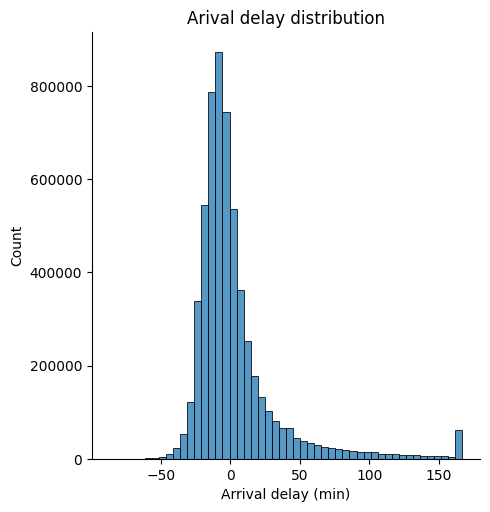

In [59]:
plt.figure(figsize=(6, 4))

sns.displot(df_flights['ARRIVAL_DELAY'], bins=50)

plt.title("Arival delay distribution")
plt.xlabel("Arrival delay (min)")
plt.show()

Text(0, 0.5, 'Delay (minutes)')

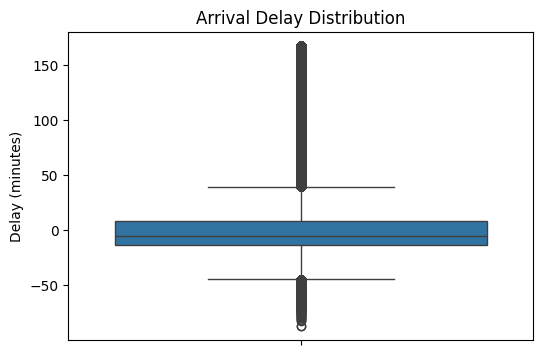

In [60]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=df_flights['ARRIVAL_DELAY'])
plt.title('Arrival Delay Distribution')
plt.ylabel('Delay (minutes)')

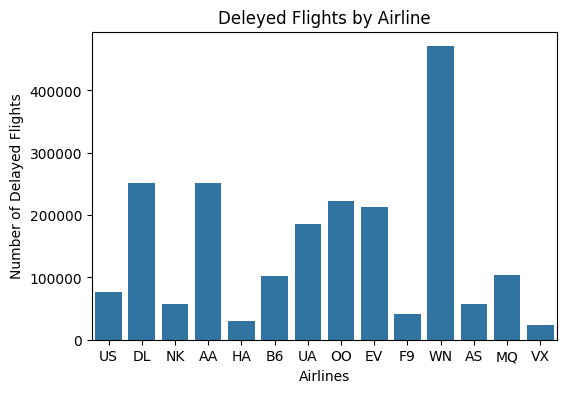

In [72]:
plt.figure(figsize=(6, 4))
delayed_by_airline = df_flights['AIRLINE'][df_flights['ARRIVAL_DELAY'] > 0]

sns.countplot(x = delayed_by_airline)
plt.title("Deleyed Flights by Airline")
plt.xlabel("Airlines")
plt.ylabel("Number of Delayed Flights")
plt.show()

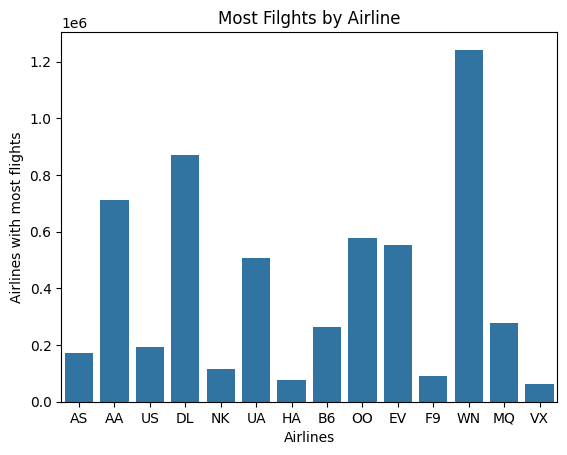

In [75]:
sns.countplot(x = df_flights['AIRLINE'])
plt.title("Most Filghts by Airline")
plt.xlabel("Airlines")
plt.ylabel("Airlines with most flights")
plt.show()

In [61]:
# Average delay by airline
airline_avg_delay = df_flights.groupby('AIRLINE')['ARRIVAL_DELAY'].mean().sort_values(ascending=False)
airline_avg_delay.round(2)

AIRLINE
NK    13.27
F9    10.37
B6     5.80
EV     5.56
MQ     5.28
OO     4.92
UA     4.24
VX     4.18
WN     3.93
US     3.25
AA     2.24
HA     1.62
DL    -0.81
AS    -1.33
Name: ARRIVAL_DELAY, dtype: float64

C:\Users\Glisa\AppData\Local\Temp\ipykernel_16600\811677276.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  airline_delayed_pct = df_flights.groupby('AIRLINE').apply(


Text(0, 0.5, '%')

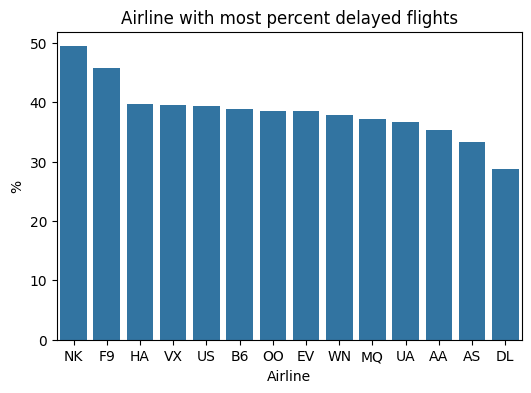

In [70]:
# Most percent of delayed flights
airline_delayed_pct = df_flights.groupby('AIRLINE').apply(
    lambda x: (x['ARRIVAL_DELAY'] > 0).sum() / len(x) * 100
).sort_values(ascending=False)

plt.figure(figsize=(6,4))

sns.barplot(x=airline_delayed_pct.index, y=airline_delayed_pct.values)
plt.title("Airline with most percent delayed flights")
plt.xlabel("Airline")
plt.ylabel("%")

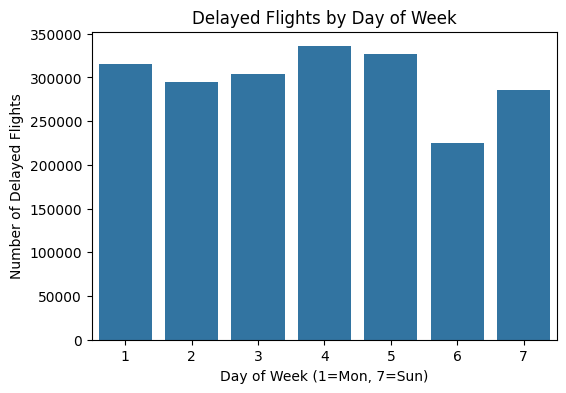

In [73]:
plt.figure(figsize=(6, 4))
delayed_by_day = df_flights[df_flights['ARRIVAL_DELAY'] > 0]['DAY_OF_WEEK']

sns.countplot(x=delayed_by_day, order=[1, 2, 3, 4, 5, 6, 7])
plt.title("Delayed Flights by Day of Week")
plt.xlabel("Day of Week (1=Mon, 7=Sun)")
plt.ylabel("Number of Delayed Flights")
plt.show()

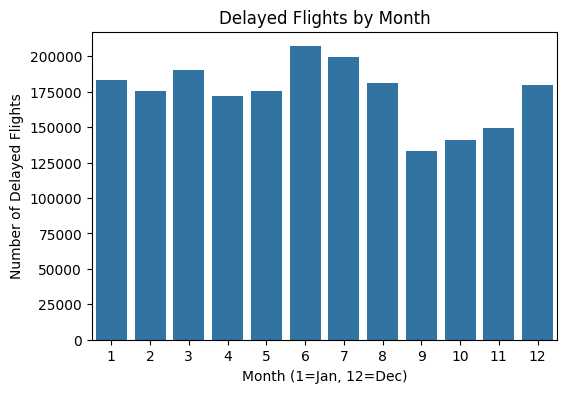

In [76]:
plt.figure(figsize=(6, 4))
delayed_by_day = df_flights[df_flights['ARRIVAL_DELAY'] > 0]['MONTH']

# Use countplot instead of histplot for categorical data
sns.countplot(x=delayed_by_day, order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
plt.title("Delayed Flights by Month")
plt.xlabel("Month (1=Jan, 12=Dec)")
plt.ylabel("Number of Delayed Flights")
plt.show()